# Virtual Concierge

## Host pre-trained endpoint for MXNET model

In this notebook we will download a pre-trained MXNET model and deploy endpoint

In [1]:
# Download pre-trained model if haven't already created from previous notebook
import os

if not os.path.exists('model.tar.gz'):
    !aws s3 cp s3://deeplens-virtual-concierge-model/mobilefacenet/model.tar.gz .

### Import model into SageMaker

Open a new sagemaker session and upload the model on to the default S3 bucket. We can use the ``sagemaker.Session.upload_data`` method to do this. We need the location of where we exported the model from MXNet and where in our default bucket we want to store the model(``/model``). The default S3 bucket can be found using the ``sagemaker.Session.default_bucket`` method.

In [2]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [3]:
model_data = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='virtual-concierge')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-423079281568


Use the ``sagemaker.mxnet.model.MXNetModel`` to import the model into SageMaker that can be deployed. We need the location of the S3 bucket where we have the model, the role for authentication and the entry_point where the model defintion is stored (``predict.py``). 

In [4]:
from sagemaker.mxnet.model import MXNetModel
sagemaker_model = MXNetModel(model_data=model_data, role=role, entry_point='predict.py')

### Create endpoint

Now the model is ready to be deployed at a SageMaker endpoint. We can use the ``sagemaker.mxnet.model.MXNetModel.deploy`` method to do this. Unless you have created or prefer other instances, we recommend using 1 ``'ml.c4.xlarge'`` instance for this training. These are supplied as arguments. 

In [5]:
import logging
logging.getLogger().setLevel(logging.WARNING)

predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-423079281568
INFO:sagemaker:Creating model with name: sagemaker-mxnet-2019-04-02-05-03-24-447
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2019-04-02-05-03-24-447


---------------------------------------------------------------------------!

### Making an inference request

Now that our Endpoint is deployed and we have a ``predictor`` object which we can call for inference.

We wiill pass a single batch of an aligned image as a numpy array in the shape the model expects, setting `content_type` and `serializer` to convert into bytes.  The `predict.py` endpoint includes overides for `model_fn` to load fully connected layer and `transform_fn` to [transform](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html?highlight=input_fn#using-input-fn-predict-fn-and-output-fn) to load numpy input and return normalized emeddings as json.

The SageMaker MXNet containers are [open source](https://github.com/aws/sagemaker-containers) if you needed more details.

In [7]:
!pygmentize predict.py

def model_fn(model_dir, prefered_batch_size=1, image_size=(112,112)):
    """Function responsible for loading the model.
    Args:
        model_dir (str): The directory where model files are stored
    Returns:
        mxnet.mod.Module: the loaded model.
    """
    
    import mxnet as mx
    import os
    import logging
    
    logging.info('Invoking model load')    
    
    data_shapes = [('data', (prefered_batch_size, 3, image_size[0], image_size[1]))]

    sym, args, aux = mx.model.load_checkpoint(os.path.join(model_dir, 'model'), 0)

    ctx = mx.cpu()
                   
    model = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
    model.bind(for_training=False, data_shapes=data_shapes)
    model.set_params(args, aux, allow_missing=True)

    return model

def transform_fn(model, request_body, request_content_type, accept_type):
    """
    Transform a request using the Gluon model. Called once per request.
    :param model: The model.
    :param request_body: The 

## Send requests

Download a sample picture, detect the first face

In [57]:
import boto3
import json
import base64

s3 = boto3.resource('s3')

# Read image from s3
image = {
    'S3Object': {
        'Bucket': 'aiml-lab-sagemaker',
        'Name': 'politicians/politicians2.jpg'
    }
}
image_object = s3.Object(image['S3Object']['Bucket'] , image['S3Object']['Name'])
payload = image_object.get()['Body'].read()

rekognition = boto3.client('rekognition')
    
# Call rekognition to get bbox
ret = rekognition.detect_faces(
    Image={
        'Bytes': payload
    },
    Attributes=['DEFAULT'],
)

print(ret['FaceDetails'][0]['BoundingBox'])

{'Width': 0.18016082048416138, 'Height': 0.47210270166397095, 'Left': 0.7550099492073059, 'Top': 0.01802222989499569}


Crop the image at the bounding box and resize for input into model

(112, 112, 3)

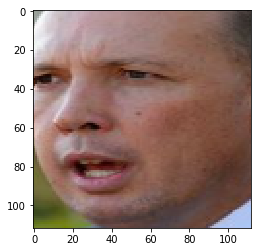

In [73]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

def crop_image(payload, bbox, image_size=(112, 112)):
    # Load image and convert to RGB space
    img = cv2.imdecode(np.frombuffer(payload, np.uint8), cv2.IMREAD_COLOR) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Crop relative to image size
    if bbox != None:
        height, width, _ = img.shape
        x1 = int(bbox['Left'] * width)
        y1 = int(bbox['Top'] * height)
        x2 = int(bbox['Left'] * width + bbox['Width'] * width)
        y2 = int(bbox['Top'] * height + bbox['Height']  * height)
        img = img[y1:y2,x1:x2,:]
    # Resize
    return cv2.resize(img, (image_size[1], image_size[0]))    

image = crop_image(payload, ret['FaceDetails'][0]['BoundingBox'])
    
# Show the last image with size
plt.imshow(image)
image.shape

Transpose the image data into a numpy array the model expects

In [74]:
model_input = np.rollaxis(image, axis=2, start=0)[np.newaxis, :]
model_input.shape

(1, 3, 112, 112)

Send the payload to the endpoint, and output the face embedding response

In [75]:
%%time

def numpy_bytes_serializer(data):
    import io
    import numpy as np
    
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

# Set the content-type to numpy 
predictor.serializer = numpy_bytes_serializer
predictor.accept = 'application/json'
predictor.content_type = 'application/x-npy'
response = predictor.predict(model_input)
print(np.array(response)[:10])

[ 0.219501    0.19605044 -0.18065766 -0.0749507   0.00539136 -0.0474967
 -0.01725377 -0.03347566  0.08176377  0.06411457]
CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 128 ms


### Batch Inference

Create a transform and from this model

In [50]:
transformer = sagemaker_model.transformer(instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2019-04-02-05-03-24-447


Save the model input as a numpy file in s3

In [90]:
!mkdir -p transform

In [83]:
# Save numpy bytes to 
for i, face in enumerate(ret['FaceDetails']):
    image = crop_image(payload, face['BoundingBox'])
    model_input = np.rollaxis(image, axis=2, start=0)[np.newaxis, :]
    filename = 'transform/{}.npy'.format(i)
    print('saving: {}'.format(filename))
    with open(filename, 'wb') as output:
        output.write(numpy_bytes_serializer(model_input))

saving: transform/0.npy
saving: transform/1.npy
saving: transform/2.npy
saving: transform/3.npy


In [ ]:
# Save the numpy image to s3 for batch transform
image_data = sagemaker_session.upload_data(path='transform', key_prefix='virtual-concierge/transform')

Run the transform process on this file

In [ ]:
transformer.serializer = numpy_bytes_serializer
transformer.accept = 'application/json'
transformer.transform(image_data, content_type='application/x-npy', split_type='Line')
transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-mxnet-2019-04-02-05-03-24-447-2019-04-02-05-51-42-574


..............................

In [ ]:
# TODO: Load the file back from s3 to read the results

### Compare to Local

Extract the model locally and call `model_fn` from `predict.py` to load the model

In [36]:
%%time

import os

if not os.path.exists('model'):
    !mkdir -p model
    !tar xvzf model.tar.gz -C ./model
    
import numpy as np
from predict import model_fn, transform_fn

model = model_fn('model')

tar: Removing leading `/' from member names
/
model-0000.params
model-shapes.json
model-symbol.json
CPU times: user 85.5 ms, sys: 30.5 ms, total: 116 ms
Wall time: 357 ms


Call `transform_fn` from `predict.py` to perform inference on test input

In [37]:
%%time

model_input = np.load('input.npy')
data = numpy_bytes_serializer(model_input)
embedding, content_type = transform_fn(model, data, 'application/x-npy', 'application/json')
print(np.array(json.loads(embedding))[:10])

[-0.10454902 -0.04392235  0.07074911  0.04567999  0.02645712  0.04673402
 -0.15382035  0.07499488  0.09955145 -0.05470199]
CPU times: user 50.3 ms, sys: 8.39 ms, total: 58.7 ms
Wall time: 59.4 ms


## Clean up

Tear down the sagemaker endpoint

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)
sagemaker.Session().delete_model()

In [30]:
import shutil

os.remove('tmp/img.png')
os.remove('input.npy')
os.remove('model.tar.gz')
shutil.rmtree('model')